## Interpolate data and plot maps in different projections

Here we will show how to plot FESOM2 data (and any unstructured and structured data for that matter) on a map with different projections. It's a simple way not to wait for ages while your cartopy script will plot one time step. As a bonus we show at the end how to create netCDF file from your interpolated data, that you can animate with ncview.

We will use a small library, called `nereus`, located two levels up from this notebook. It's just a collection of helper functions, that makes code more compact.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
import dask
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append("../../")
import nereus as nr

In [2]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

In [3]:
data = cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.ocean.native']['daily'].to_dask()

We are going to work with daily FESOM2 data

In [4]:
data

<xarray.Dataset>
Dimensions:  (time: 730, x: 7402886)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T23:54:00 ... 1951-12-31T23:54:00
Dimensions without coordinates: x
Data variables:
    MLD1     (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    MLD2     (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    a_ice    (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    m_ice    (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    ssh      (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    sss      (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    sst      (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    uice     (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    vice     (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
Attributes: (12/21)
    CDI:                                 Climate Data Interface version 2.2.4...
    Conventions:                         CF-1.6
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       d6a683a9
    FESOM_MeshPath:                      /scratch/a/a270228/ifs_inputs/fesom/...
    ...                                  ...
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      7
    FESOM_use_wsplit:                    1
    FESOM_autorotate_back_to_geo:        1
    history:                             Wed Nov 01 00:21:09 2023: cdo --ecco...
    CDO:                                 Climate Data Operators version 2.2.2...

In [5]:
grid = cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.ocean.native']['node_grid'].to_dask()
model_lon = grid.grid_center_lon.values
model_lat = grid.grid_center_lat.values
# put coordinates to -180 180 format
model_lon = np.where(model_lon>180, model_lon-360, model_lon)

In [8]:
bbox = [-100, 0, 20, 60]
# bbox = [-15.4, 130.0, -10, 59.05]

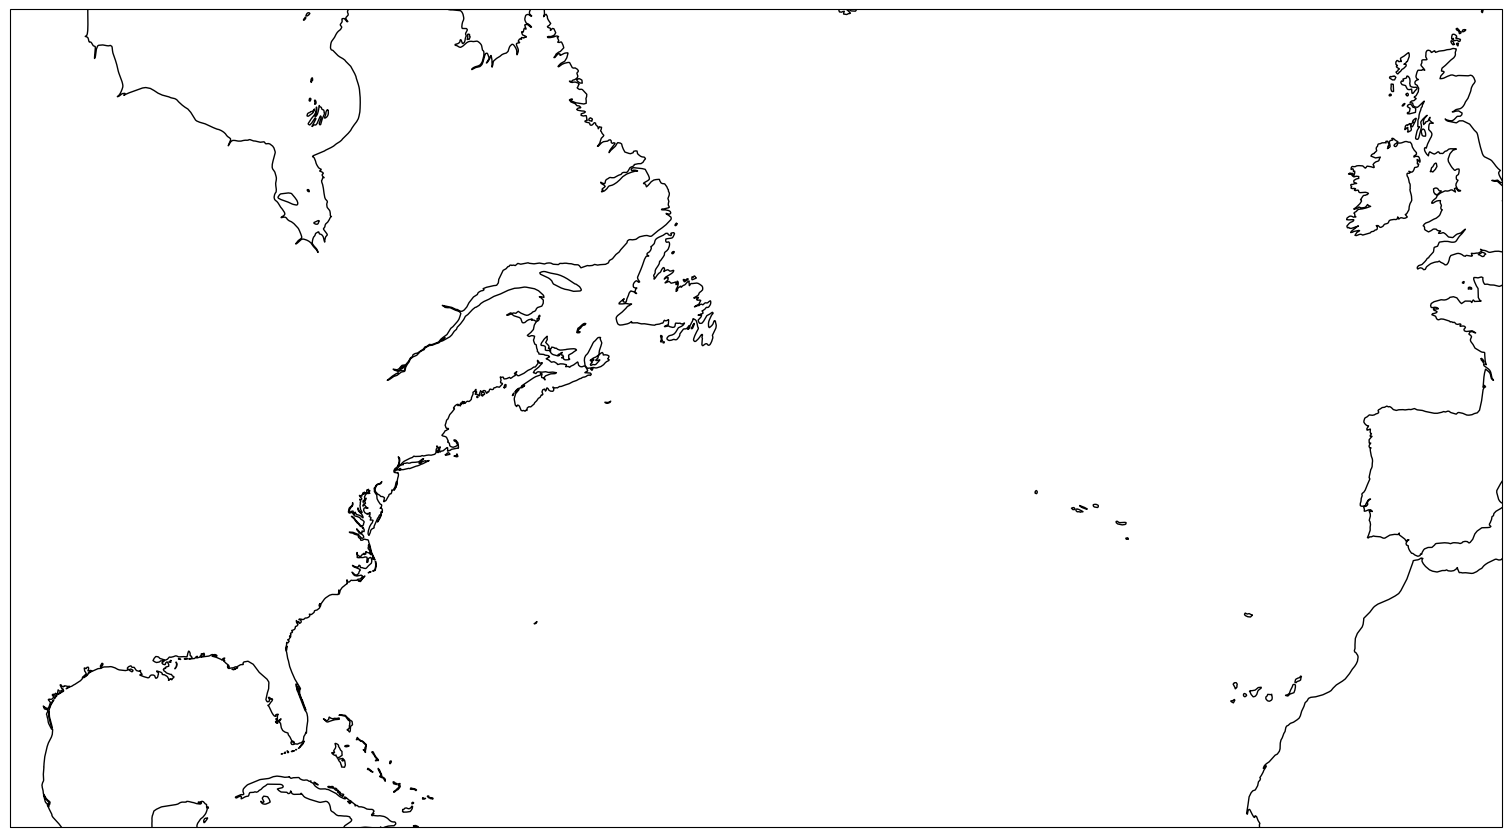

In [9]:
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Mercator()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines("50m")

In [10]:
x, y, lon2, lat2 = nr.projected_grid_to_platecarree_pyproj(bbox, [1000, 500], projection="World_Mercator", n_points=100)

In [11]:
distances, inds = nr.create_indexes_and_distances(model_lon, model_lat, lon2, lat2, k=1, workers=10)

In [60]:
data_sample = data['MLD2'][390,:]
# data_sample2 = data['2t'][1106,:]

radius_of_influence=10000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

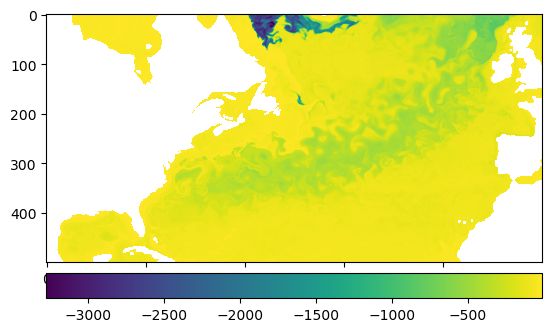

In [61]:
plt.imshow(np.flipud(data_interpolated))
plt.colorbar(orientation='horizontal', pad=0.03)

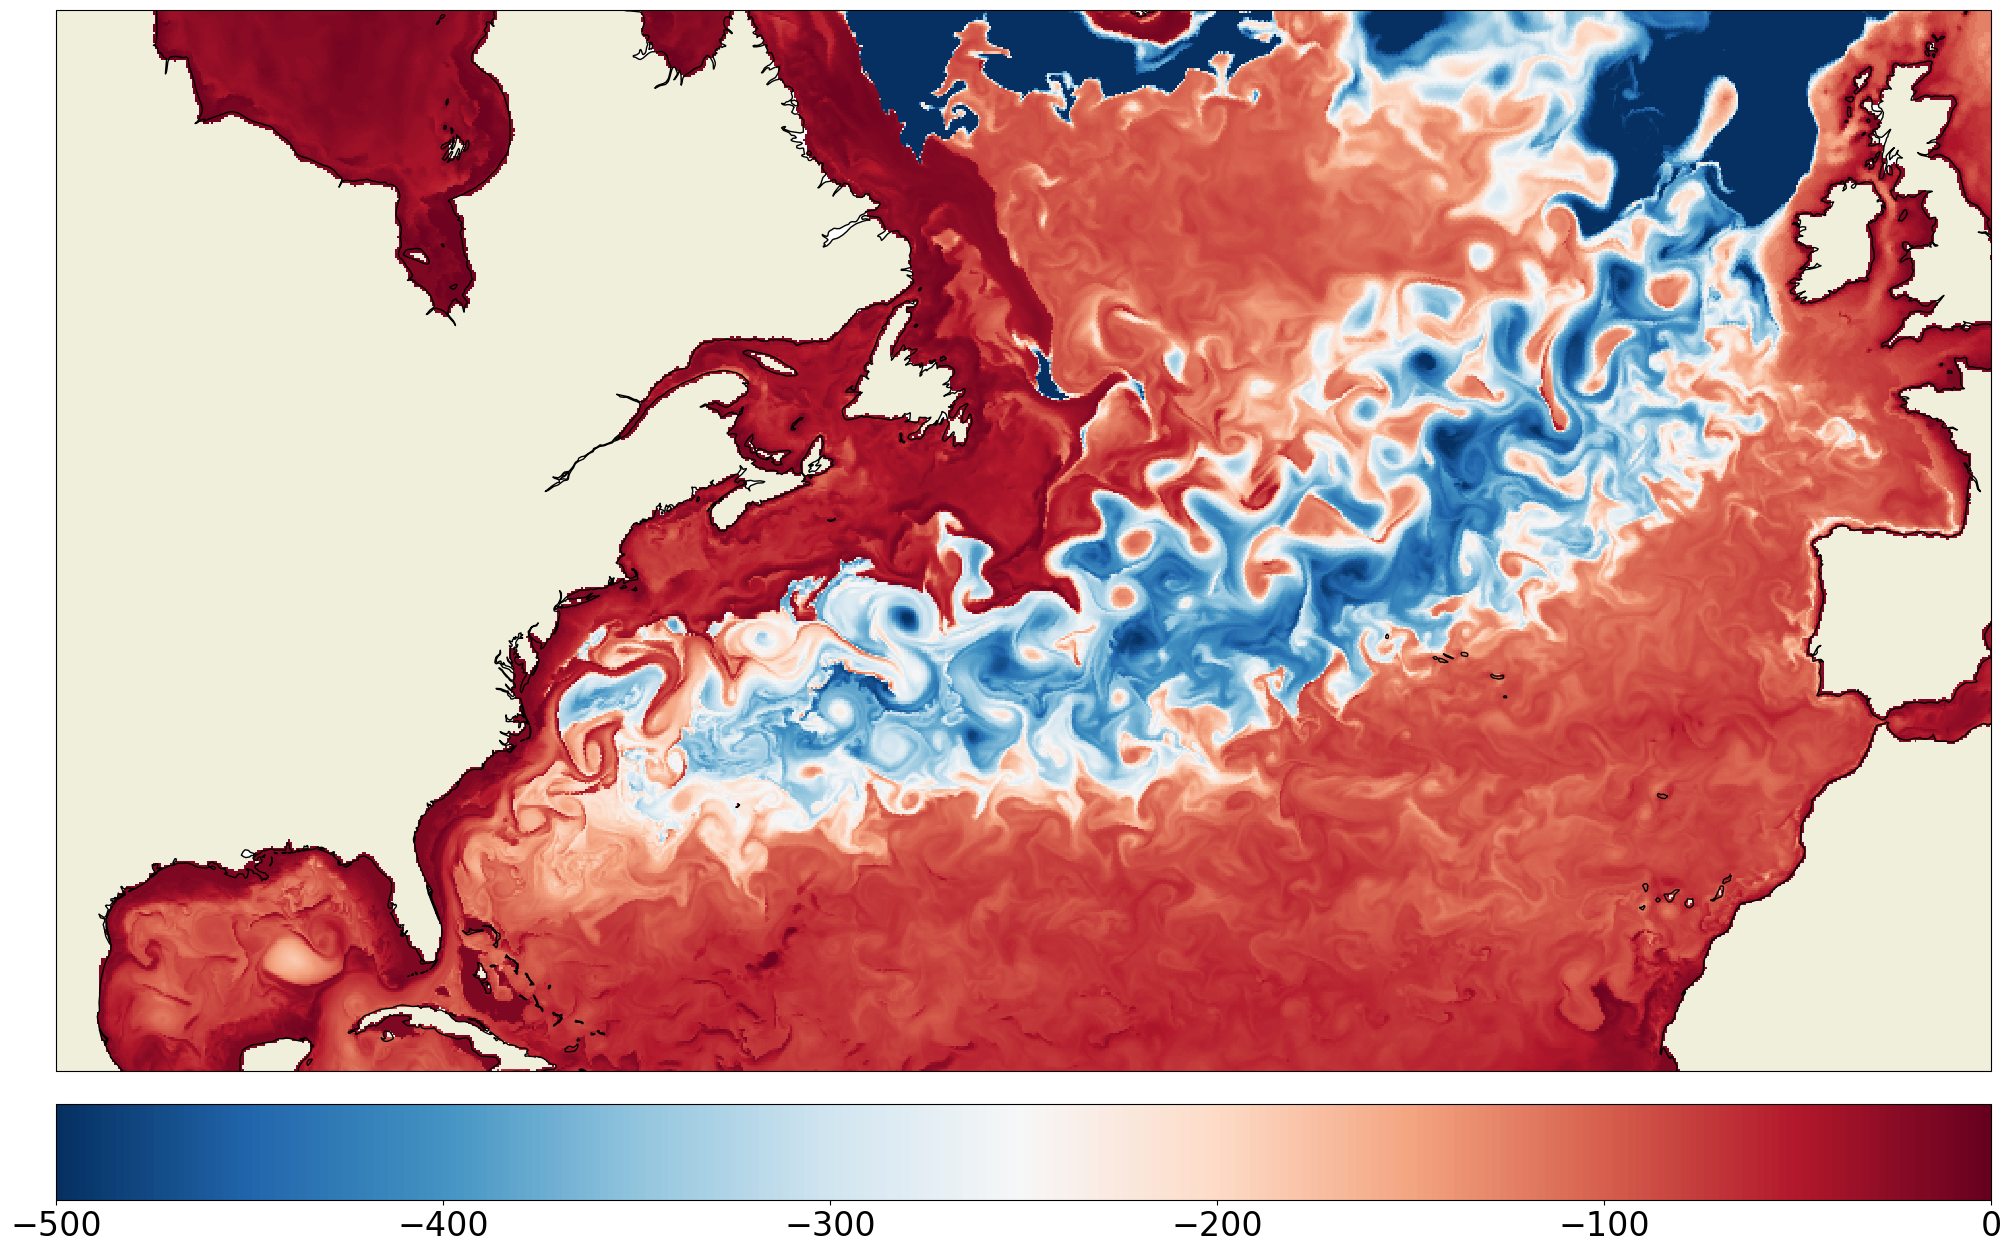

In [63]:
projection_ccrs = ccrs.Mercator()
fig, ax = plt.subplots(
                    1,
                    1,
                    subplot_kw=dict(projection=ccrs.Mercator()),
                    constrained_layout=True,
                    figsize=(20, 30),
                )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
im1 = ax.imshow(np.flipud(data_interpolated), cmap=cm.RdBu_r,
                vmin=-500, vmax=0,
                extent=(x.min(), x.max(), y.min(), y.max()),
                interpolation='nearest', 
               transform=ccrs.Mercator())
ax.coastlines()
cb = fig.colorbar(im1, orientation='horizontal', pad=0.01)
cb.ax.tick_params(labelsize=24)
ax.add_feature(cfeature.LAND)

## North Polar stereo projection

In [64]:
bbox = [-180, 180, 60, 90]

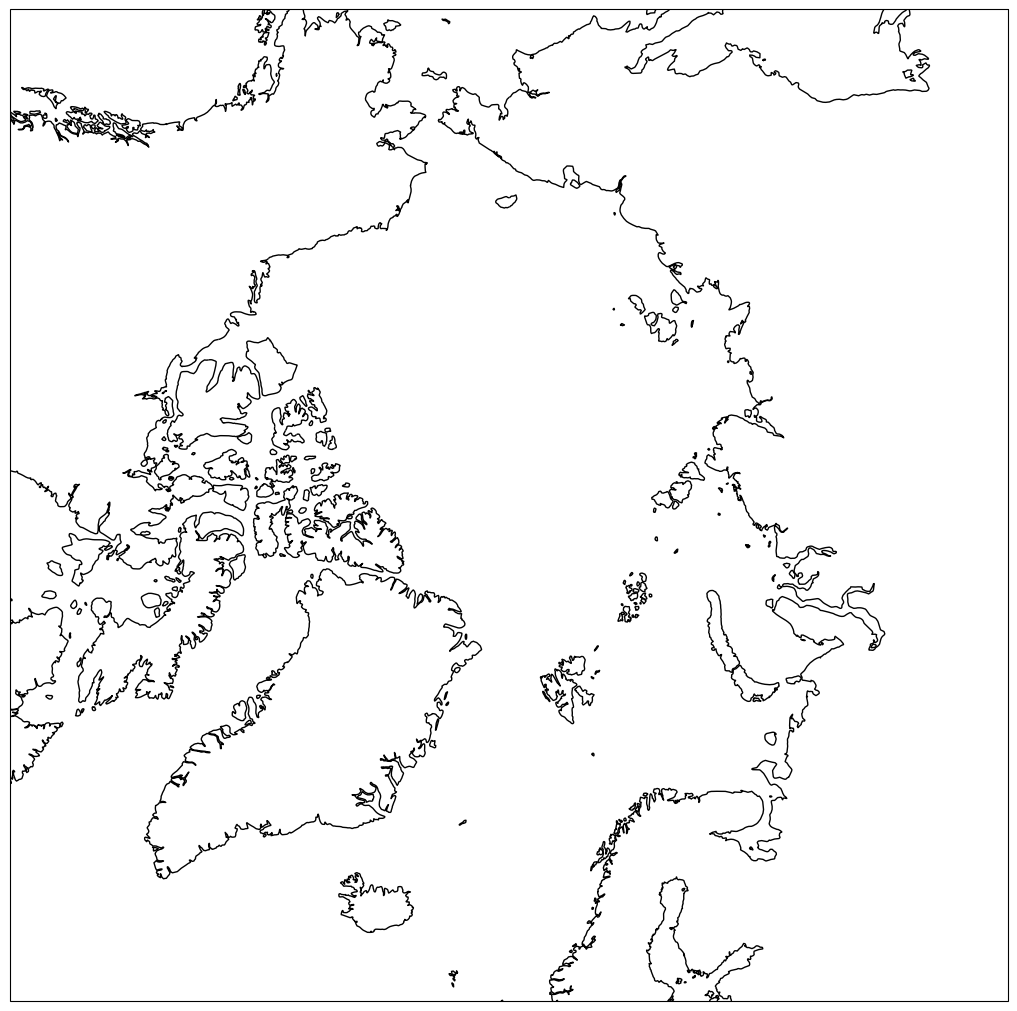

In [65]:
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines()

We need to define NP projection to match the one from cartopy

In [66]:
from pyproj import CRS

In [67]:
custom_north_polar_stereo = CRS.from_string("+proj=stere +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [68]:
x, y, lon2, lat2 = nr.projected_grid_to_platecarree_pyproj(bbox, [500, 500], projection=custom_north_polar_stereo, n_points=100)

In [69]:
distances, inds = nr.create_indexes_and_distances(model_lon, model_lat, lon2, lat2, k=1, workers=10)

In [70]:
data_sample = data['m_ice'][360,:]

radius_of_influence=5000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

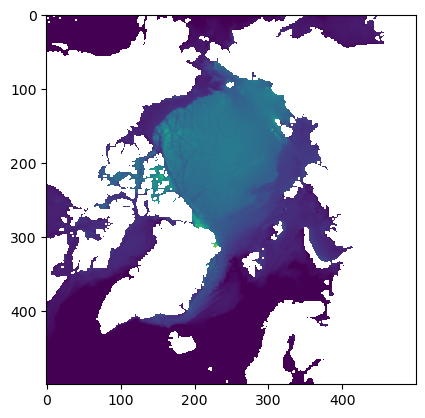

In [71]:
# plt.figure(figsize=(15,15))
plt.imshow(np.flipud(data_interpolated))

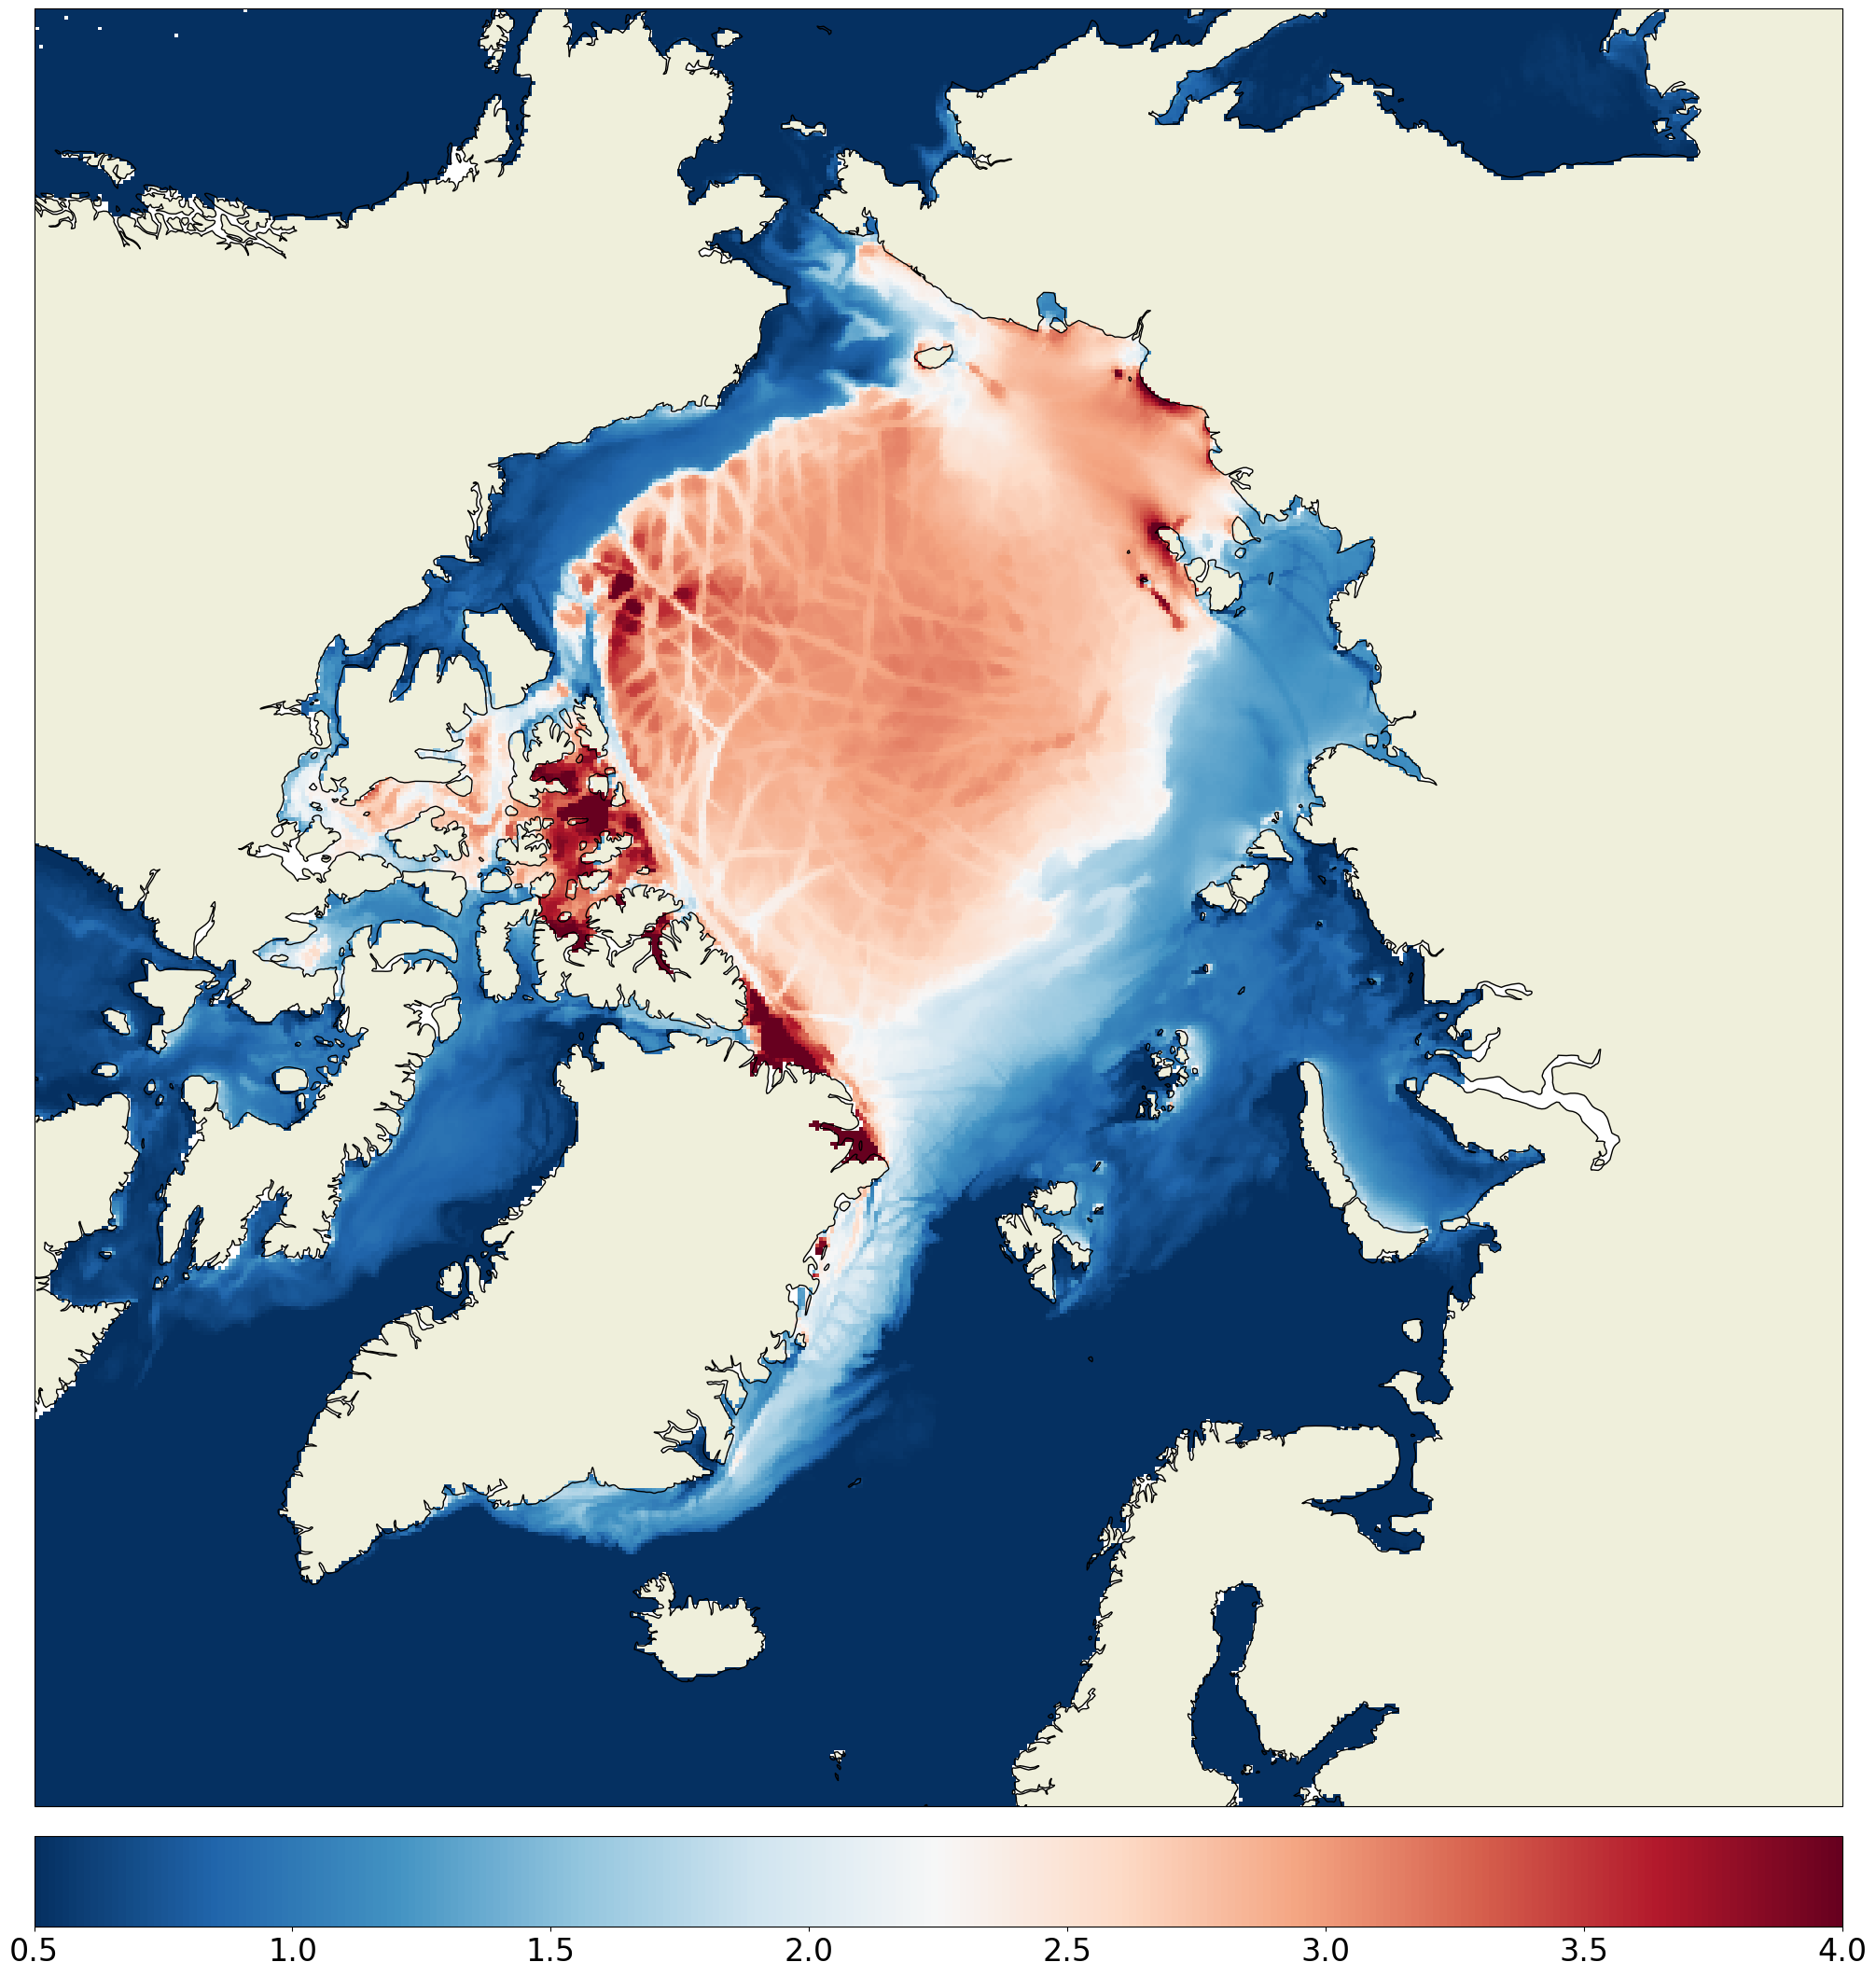

In [72]:
projection_ccrs = ccrs.NorthPolarStereo()
fig, ax = plt.subplots(
                    1,
                    1,
                    subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
                    constrained_layout=True,
                    figsize=(20, 30),
                )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
im1 = ax.imshow(np.flipud(data_interpolated), cmap=cm.RdBu_r,
                vmin=0.5, vmax=4,
                extent=(x.min(), x.max(), y.min(), y.max()),
                interpolation='nearest', 
               transform=ccrs.NorthPolarStereo())
ax.coastlines()
cb = fig.colorbar(im1, orientation='horizontal', pad=0.01)
cb.ax.tick_params(labelsize=24)
ax.add_feature(cfeature.LAND)

## Interpolate data in NP stereo and save them as netCDF

In [73]:
import xarray as xr

We reuse arrays created for NP stereo example here. Only first 365 time steps interpolated, which takes about a minute.

In [78]:
%%time
data_interpolated_array = []
ntimesteps = 30
for i in range(ntimesteps):
    data_sample = data['m_ice'][i,:]

    radius_of_influence=5000
    data_interpolated = data_sample.values[inds]
    data_interpolated[distances >= radius_of_influence] = np.nan
    data_interpolated = data_interpolated.reshape(lon2.shape)
    data_interpolated = np.ma.masked_invalid(data_interpolated)
    data_interpolated_array.append(data_interpolated)

CPU times: user 166 ms, sys: 277 ms, total: 444 ms
Wall time: 580 ms


In [79]:
data_interpolated_array = np.array(data_interpolated_array, dtype="float32")

In [80]:
out = xr.Dataset(
        {"ice_thickness": (["time", "lat", "lon"], data_interpolated_array)},
        coords={
            "time": data['m_ice'].time[:ntimesteps].values,
            "lon": (["lon"], x),
            "lat": (["lat"], y),
            "longitude": (["lat", "lon"], lon2),
            "latitude": (["lat", "lon"], lat2),
        },
        # attrs=data.attrs,
    )

In [81]:
out.to_netcdf('./out.nc')